In [38]:
%load_ext autoreload
%autoreload 2
import pickle
import torch
import sys
sys.path.insert(0, '..')

with open('../data/RIM', 'rb') as f:
    t, ii, [V] = pickle.load(f)
    
print(t.shape)
print(ii.shape)
print(V.shape)

i = torch.Tensor(ii[:,:,None])
V = torch.Tensor(V)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(275,)
(275, 11)
(275, 11)


(275, 1, 1, 11, 1)
torch.Size([1375, 11])


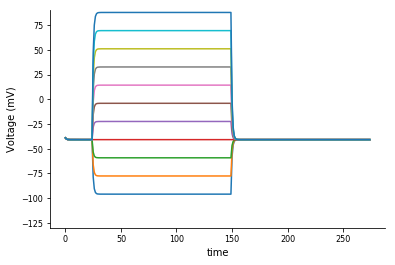

In [39]:
import odynn
from odynn.models import LeakyIntegrate, CElegansNeuron
import pylab as plt
import seaborn as sns

dt = t[1] - t[0]
N_parallel = 1000

def init(tens=True, par=N_parallel):
    return LeakyIntegrate.create_default(1, par, tensors=tens, dt=dt)

obj = init(False,1)
X = obj.calculate(ii)#.detach().numpy()
print(X.shape)
print(V.shape)

plt.plot(X[:,0,0,:,0])
plt.ylim(-130, 90)
plt.ylabel('Voltage (mV)')
plt.xlabel('time')
sns.despine()


  0%|          | 0/1001 [00:00<?, ?it/s]

tensor(130.1241, grad_fn=<MeanBackward1>) tensor(130.1241, grad_fn=<MinBackward1>)


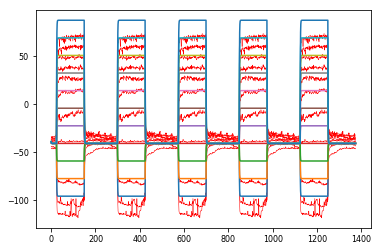


  3%|▎         | 35/1001 [00:23<11:17,  1.43it/s]

KeyboardInterrupt: 

In [40]:
from tqdm import tqdm

"""Optimize correlation"""

obj = init()
losses = []
# Define loss function
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 0.1
optimizer = torch.optim.Adam([k for k in obj.parameters.values()], lr=learning_rate)

for e in tqdm(range(1001)):
    y = obj.calculate(i)

    loss = (y[:,0,:,0,:].permute(2,0,1) - V).pow(2).mean((1,2))
    
    losses.append(loss)
    #Upgrade variables
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()

    obj.apply_constraints()
    
    
    if e%50 == 0:
        print(loss.mean(), loss.min())
        best = loss.argmin()
        plt.plot(V.numpy(), 'r', linewidth=0.5)
        plt.plot(y[:,0,:,0,best].detach().cpu().numpy())
        plt.show()
#         print(np.corrcoef(i_forced[:,0].detach().cpu().numpy(), y[:,0].detach().cpu().numpy()) )
#         plt.plot(i.detach().numpy())
#         plt.show()

plt.plot([l.detach().numpy() for l in losses], linewidth=0.2)
plt.yscale('log')
plt.show()

In [6]:
best = loss.argmin()
best_p = {k: v[0,best] for k,v in obj.parameters.items()}
print(best_p)

# for n in range(obj.parallel):
#     plt.plot(V.numpy(), 'r', linewidth=0.5)
#     plt.plot(y[:,0,:,0,n].detach().cpu().numpy())
#     plt.show()

{'C_m': tensor(4.9870), 'g_L': tensor(0.2717), 'E_L': tensor(-40.8227, grad_fn=<SelectBackward>)}
